# Import libraries

In [1]:
%matplotlib inline
import pandas as pd
import csv
import re
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import describe
from statsmodels.tsa.stattools import grangercausalitytests
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

# Data dictionary

* Date - Date of the crash

* Time - Time of the crash

* Location - Location of the crash
 
* Operator - Airline of the plane

* Route - Route taken by plane

* Type - Type of the plane

* Aboard - Number of people aboard

* Fatalities - Number of lethal outcomes

* Ground - Total people killed due to crash on the ground (for example, those who were not on board, but died due to the crash)

* Summary - Brief summary of the case

# Links
    
* <a href="https://urbaninstitute.github.io/graphics-styleguide/" target="_blank">Graphics styleguide</a>
* <a href="https://raw.githubusercontent.com/imsouza/airplane-crash/main/Airplane_Crashes_and_Fatalities_Since_1908.csv" target="_blank">Dataset used</a>

# Data preparation

In [2]:
data = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')

In [3]:
data.drop(['Flight #', 'Registration', 'cn/In'], axis=1, inplace=True)

In [4]:
def drop_missing_data_rows(data: pd.DataFrame):
    missing_data_rows = pd.isna(data["Date"])
    missing_data_rows = pd.isna(data["Aboard"])
    missing_data_rows = pd.isna(data["Fatalities"])
    missing_data_rows = pd.isna(data["Ground"])
    return data.drop(data[missing_data_rows].index, axis=0)

In [5]:
def convert_float_to_int (data: pd.DataFrame):
    columns = data.select_dtypes(include=['float64']).columns
    data[columns] = data[columns].apply(pd.to_numeric, downcast='integer', errors='coerce')
    return data

In [6]:
data = drop_missing_data_rows(data)
data = convert_float_to_int(data)

In [7]:
data['Location'].fillna("Unknown", inplace=True)
data['Operator'].fillna("Unknown", inplace=True)
data['Route'].fillna("Unknown", inplace=True)
data['Type'].fillna("Unknown", inplace=True)
data['Summary'].fillna("Unknown", inplace=True)

In [8]:
data['Date'] = pd.to_datetime(data['Date']).dt.date
data['Date'] = pd.DatetimeIndex(data['Date'])
date_index = data.set_index('Date')

In [9]:
data['Date'].value_counts().sum()

5246

In [10]:
times  = []

for i in range(data.shape[0]):
    try:
        times.append(int(data['Time'][i][0:2]))
    except:
        continue

data_hours = pd.DataFrame()
data_hours['Time'] = pd.Series(times)
data['Time'] = data_hours['Time']

data = convert_float_to_int(data)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5246 entries, 0 to 5267
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5246 non-null   datetime64[ns]
 1   Time        2994 non-null   float64       
 2   Location    5246 non-null   object        
 3   Operator    5246 non-null   object        
 4   Route       5246 non-null   object        
 5   Type        5246 non-null   object        
 6   Aboard      5236 non-null   float64       
 7   Fatalities  5246 non-null   int16         
 8   Ground      5246 non-null   int16         
 9   Summary     5246 non-null   object        
dtypes: datetime64[ns](1), float64(2), int16(2), object(5)
memory usage: 549.4+ KB


In [12]:
data.describe()

,Time,Aboard,Fatalities,Ground
count,2994.000000,5236.000000,5246.000000,5246.000000
mean,12.889780,27.589190,20.089592,1.608845
std,6.021168,43.109636,33.226782,53.987827
min,0.000000,0.000000,0.000000,0.000000
25%,9.000000,5.000000,3.000000,0.000000
50%,13.000000,13.000000,9.000000,0.000000
75%,18.000000,30.000000,23.000000,0.000000
max,23.000000,644.000000,583.000000,2750.000000


In [13]:
data.shape

(5246, 10)

In [14]:
data.isnull().sum()

Date             0
Time          2252
Location         0
Operator         0
Route            0
Type             0
Aboard          10
Fatalities       0
Ground           0
Summary          0
dtype: int64

In [15]:
data.head()

,Date,Time,Location,Operator,Route,Type,Aboard,Fatalities,Ground,Summary
0,1908-09-17,17.0,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1,0,"During a demonstration flight, a U.S. Army fly..."
1,1912-07-12,6.0,"AtlantiCity, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,5,0,First U.S. dirigible Akron exploded just offsh...
2,1913-08-06,18.0,"Victoria, British Columbia, Canada",Private,Unknown,Curtiss seaplane,1.0,1,0,The first fatal airplane accident in Canada oc...
3,1913-09-09,10.0,Over the North Sea,Military - German Navy,Unknown,Zeppelin L-1 (airship),20.0,14,0,The airship flew into a thunderstorm and encou...
4,1913-10-17,1.0,"Near Johannisthal, Germany",Military - German Navy,Unknown,Zeppelin L-2 (airship),30.0,30,0,Hydrogen gas which was being vented was sucked...


In [16]:
data.tail()

,Date,Time,Location,Operator,Route,Type,Aboard,Fatalities,Ground,Summary
5262,2009-05-03,NaN,"Near El Alto de Rubio, Venezuela",Military - Venezuelan Army,Patrol,Mi-35,18.0,18,0,The helicopter was patrolling along the Venezu...
5263,2009-05-20,NaN,"Near Madiun, Indonesia",Military - Indonesian Air Force,Jakarta - Maduin,Lockheed C-130 Hercules,112.0,98,2,"While on approach, the military transport cras..."
5265,2009-06-01,NaN,"AtlantiOcean, 570 miles northeast of Natal, Br...",Air France,Rio de Janeiro - Paris,Airbus A330-203,228.0,228,0,The Airbus went missing over the AtlantiOcean ...
5266,2009-06-07,NaN,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,Lourdes de BlanSablon - Port Hope Simpson,Britten-Norman BN-2A-27 Islander,1.0,1,0,The air ambulance crashed into hills while att...
5267,2009-06-08,NaN,"State of Arunachal Pradesh, India",Military - Indian Air Force,Mechuka for Jorhat,Antonov An-32,13.0,13,0,The military transport went missing while en r...


# Data analysis and visualization

In [17]:
def plot_data(dataset, title, labelx, labely, kind='line', ts=False, elbow=False, ac=False):
    sns.set_palette('Accent')
    sns.set_style('darkgrid')
    
    ax = None;
    
    if ts:
        ax = sns.lineplot(x = labelx, y = labely, data = dataset)
    elif ac:
        ax = autocorrelation_plot(dataset)
    else:
        if (elbow):
            ax = dataset.plot(kind=kind, marker='*')
        else:
            ax = dataset.plot(kind=kind)
        
    ax.figure.set_size_inches(12,6)
    ax.set_title(title, loc='left', fontsize=18)
    ax.set_xlabel(labelx, fontsize=14)
    ax.set_ylabel(labely, fontsize=14)
    ax = ax

In [18]:
def plot_multiple_data(dataset, x, y1, y2, y3, title):
    sns.set_palette('Accent')
    sns.set_style('darkgrid')
        
    plt.figure(figsize=(16,12))
    ax = plt.subplot(3,1,1)
    ax.set_title(title, fontsize=18, loc='left')
    sns.lineplot(x=x, y=y1, data=dataset)
    plt.subplot(3,1,2)
    sns.lineplot(x=x, y=y2, data=dataset)
    plt.subplot(3,1,3)
    sns.lineplot(x=x, y=y3, data=dataset)
    ax=ax    

## Count of crashes by Decade

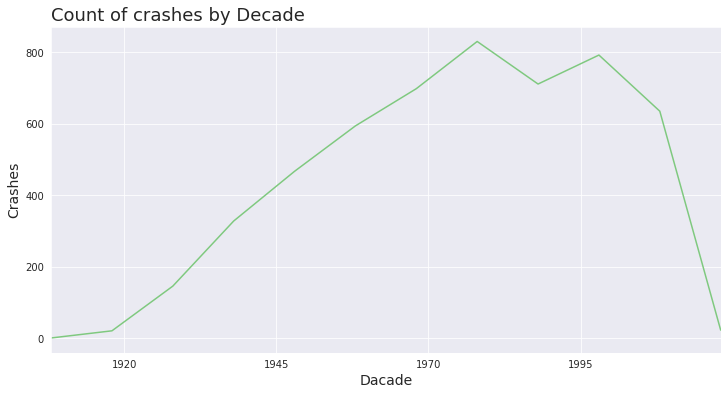

In [19]:
crashes_by_decade = date_index.resample('10y').size()

plot_data(crashes_by_decade, 'Count of crashes by Decade', 'Dacade', 'Crashes')

## Count of crashes by Year

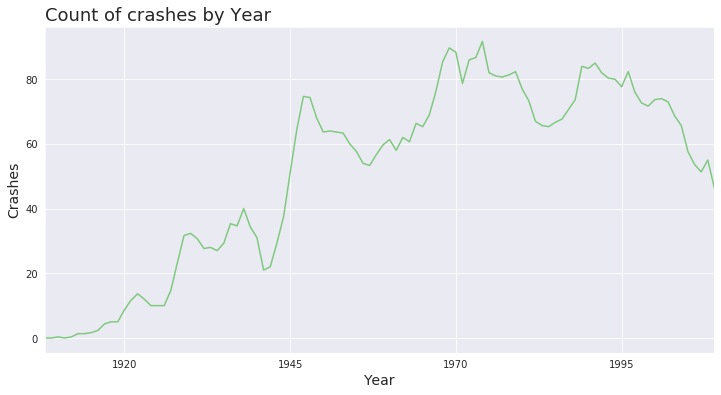

In [20]:
crashes_by_year = date_index.resample('1y').size().rolling(3).mean().fillna(0)

plot_data(crashes_by_year, 'Count of crashes by Year', 'Year', 'Crashes')

## Count of crashes by Day of Week

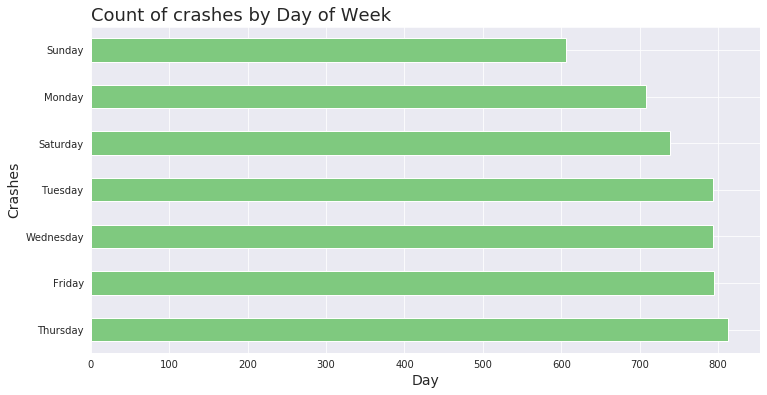

In [21]:
date_day = pd.DataFrame()
date_day = pd.Series(data['Date']).dt.day_name()

plot_data(date_day.value_counts(), 'Count of crashes by Day of Week', 'Day', 'Crashes', 'barh')

## Count of crashes by Month

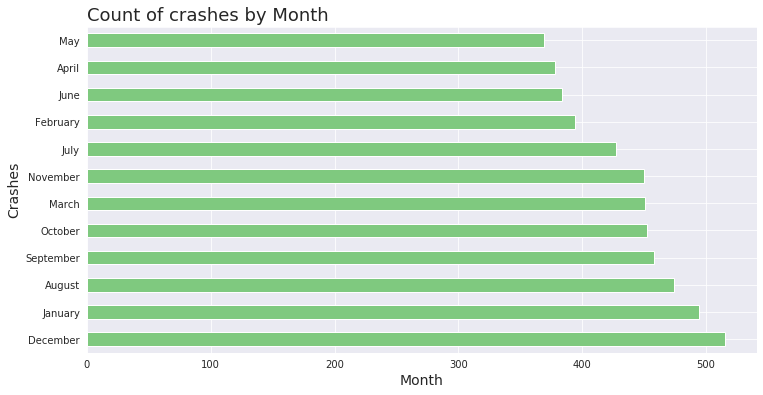

In [22]:
date_month = pd.DataFrame()
date_month.index.name = 'index'
date_month['Month'] = pd.Series(data['Date'])
date_month['Month'] = date_month['Month'].dt.month_name()

plot_data(date_month['Month'].value_counts(), 'Count of crashes by Month', 'Month', 'Crashes', 'barh')

## Count of crashes by Season

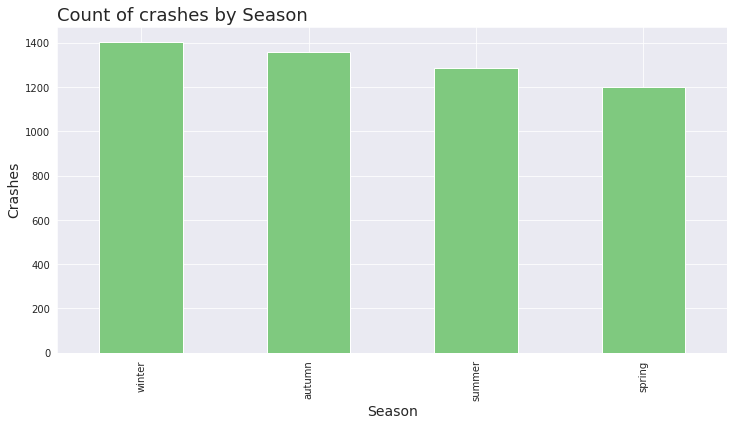

In [23]:
date_season = pd.DataFrame()
date_season = pd.Series(data['Date']).dt.month

def get_season(month):
    if month >= 3 and month <= 5:
        return 'spring'
    elif month >= 6 and month <= 8:
        return 'summer'
    elif month >= 9 and month <= 11:
        return 'autumn'
    else:
        return 'winter'

date_season = date_season.apply(get_season)

crashed_by_season = date_season.groupby(date_season).count().sort_values(ascending=False)

plot_data(crashed_by_season, 'Count of crashes by Season', 'Season', 'Crashes', 'bar')

## How many people were on board in each Fatality

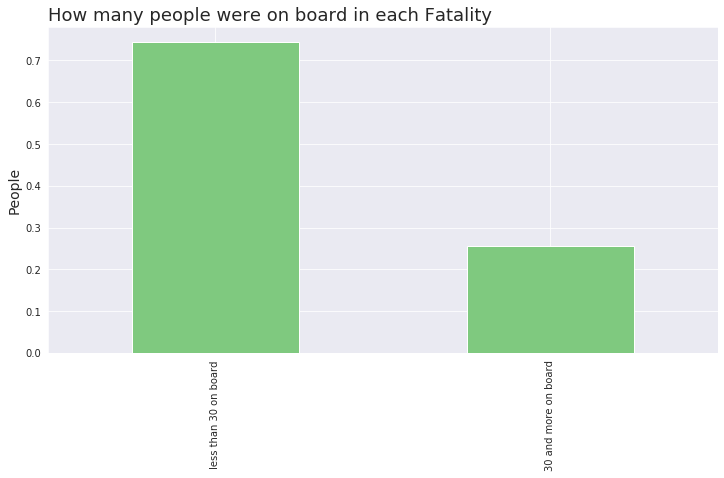

In [24]:
ax = pd.Series(
    np.where(data['Aboard'] > 29,'30 and more on board','less than 30 on board')).value_counts(
    normalize = True
    )

plot_data(ax, 'How many people were on board in each Fatality', '', 'People', 'bar')

## Count of hijacked planes crashed by year

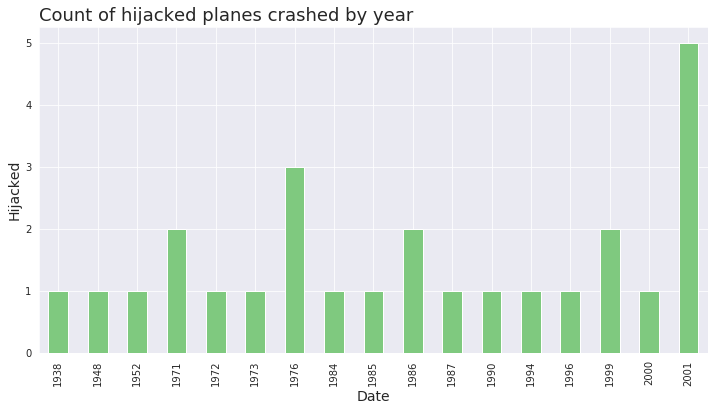

In [25]:
date_year = pd.DataFrame()
date_year['Year'] = pd.Series(data['Date']).dt.year
date_year['Summary'] = pd.Series(data['Summary'])

ax = date_year[date_year['Summary'].str.contains('hijacke')]['Year'].value_counts().sort_index()

plot_data(ax, 'Count of hijacked planes crashed by year', 'Date', 'Hijacked', 'bar')

## Count of missing planes by year

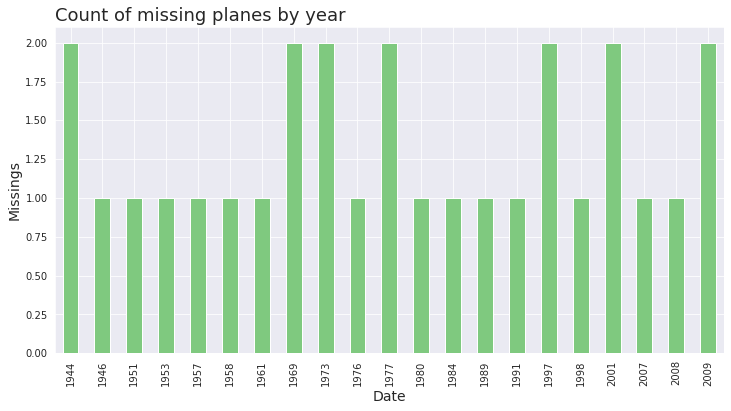

In [26]:
date_year['Year'] = pd.Series(data['Date']).dt.year
date_year['Summary'] = pd.Series(data['Summary'])

ax = date_year[date_year['Summary'].str.contains('missing')]['Year'].value_counts().sort_index()

plot_data(ax, 'Count of missing planes by year', 'Date', 'Missings', 'bar')

## Analysis of brazilian flights

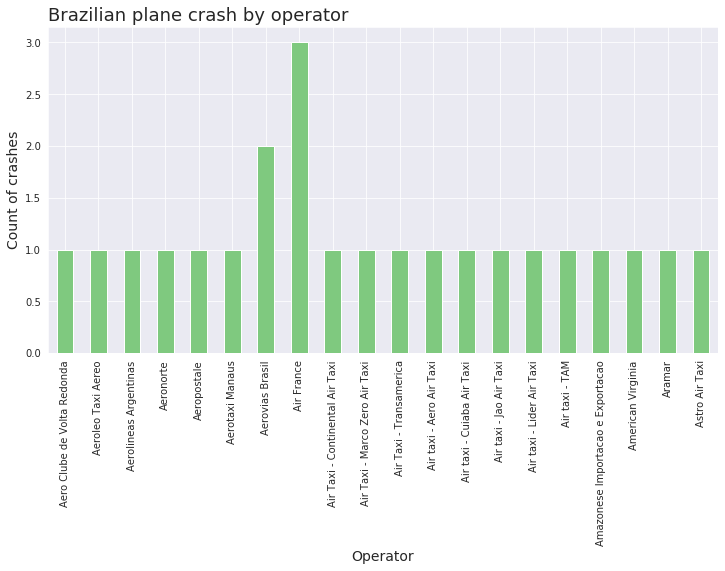

In [27]:
filter_br = data['Location'].str.contains('Brazil')

ax = data[filter_br]['Operator'].value_counts().sort_index().head(20)

plot_data(ax, 'Brazilian plane crash by operator', 'Operator', 'Count of crashes', 'bar')

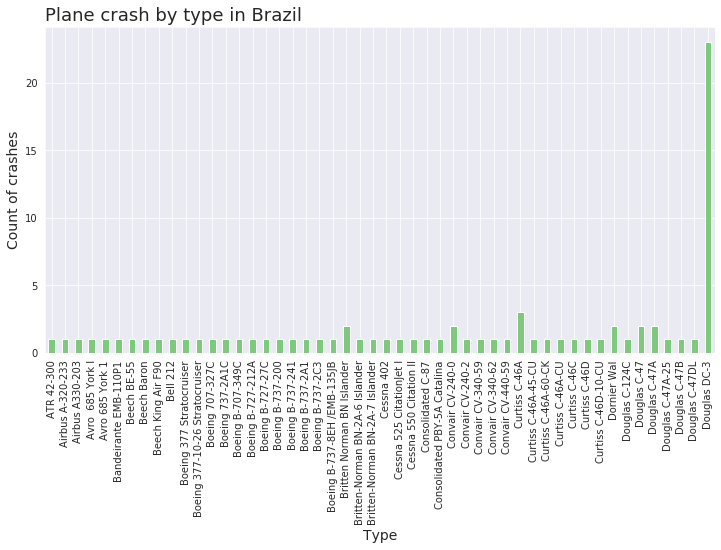

In [28]:
ax = data[filter_br]['Type'].value_counts().sort_index().head(50)

plot_data(ax, 'Plane crash by type in Brazil', 'Type', 'Count of crashes', kind='bar')

## Time series analysis and visualization

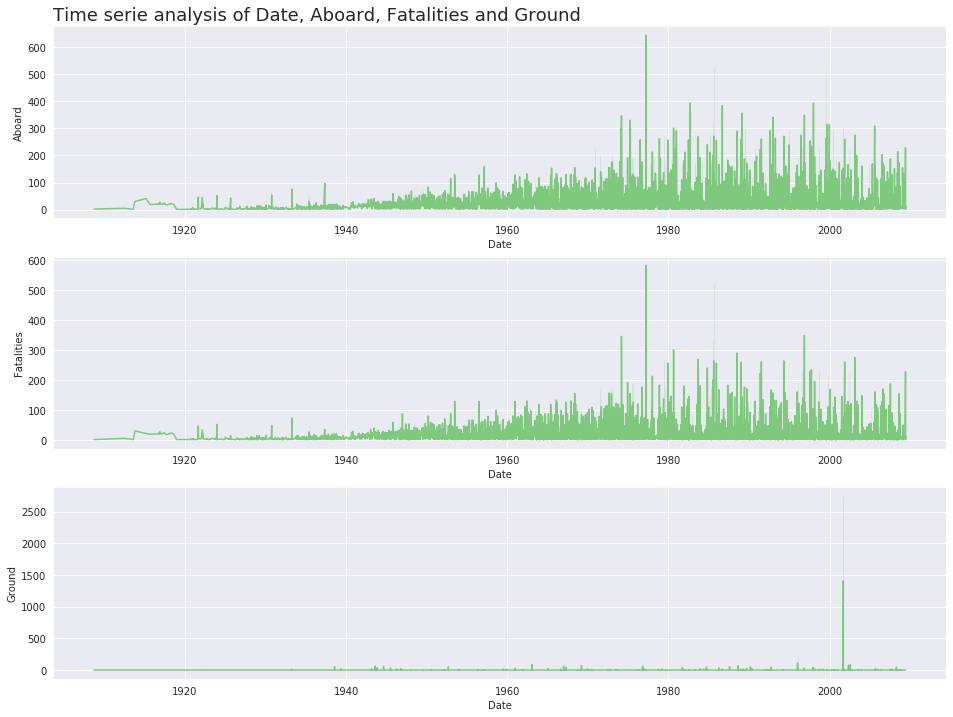

In [29]:
plot_multiple_data(data, 'Date', 'Aboard', 'Fatalities', 'Ground', 'Time serie analysis of Date, Aboard, Fatalities and Ground')

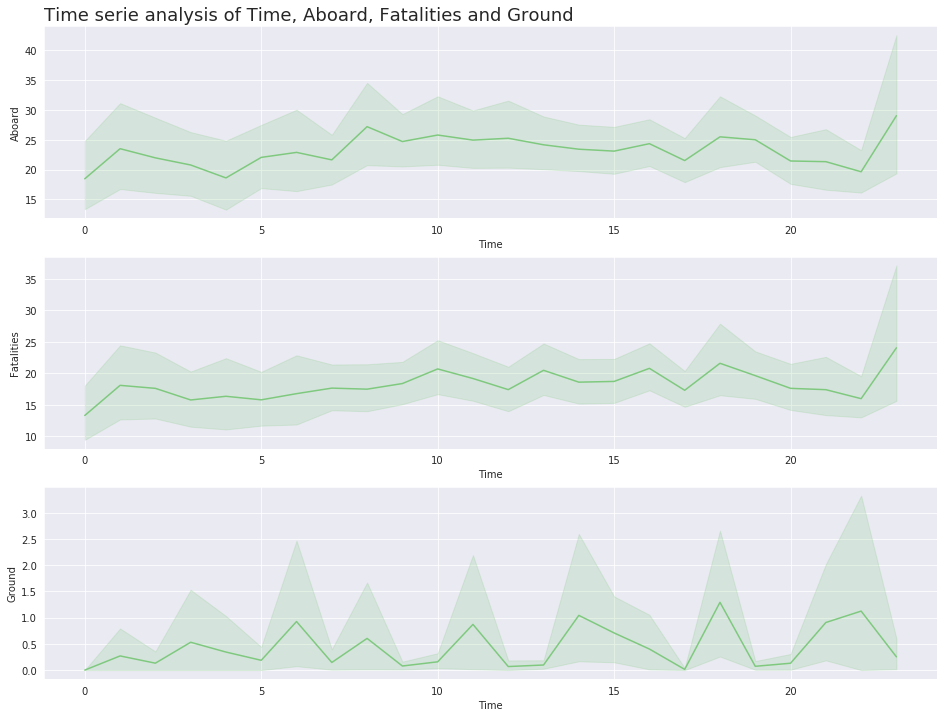

In [30]:
plot_multiple_data(data, 'Time', 'Aboard', 'Fatalities', 'Ground', 'Time serie analysis of Time, Aboard, Fatalities and Ground')

### Autocorrelation plot

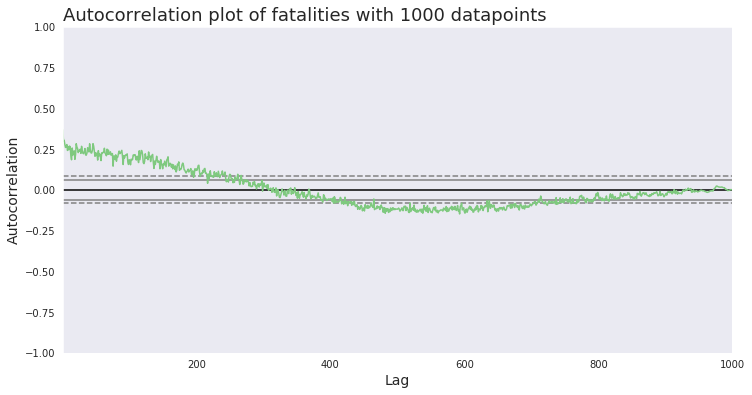

In [31]:
plot_data(data['Fatalities'].head(1000), 'Autocorrelation plot of fatalities with 1000 datapoints', 'Lag', 'Autocorrelation', 'line', ac=True)

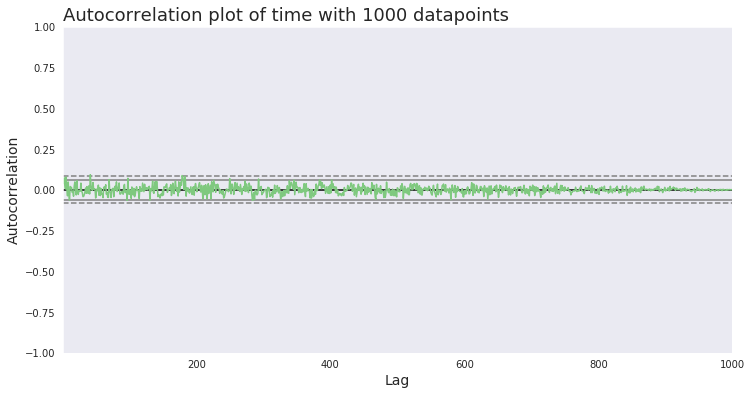

In [32]:
plot_data(data['Time'].head(1000), 'Autocorrelation plot of time with 1000 datapoints', 'Lag', 'Autocorrelation', 'line', ac=True)

### Seasonal decompose

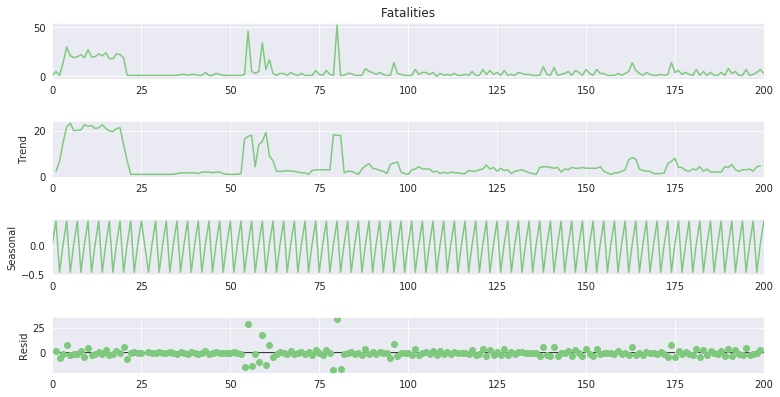

In [61]:
seasonal_ = seasonal_decompose(data['Fatalities'].head(200), period=3)

sns.set_palette('Accent')
sns.set_style('darkgrid')

ax = seasonal_.plot();
ax.set_size_inches((12, 6))
ax = ax

## Plane crashes in WW1 and WWII

In [34]:
crashes_ww = date_year['Year'].groupby(date_year['Year']).count()

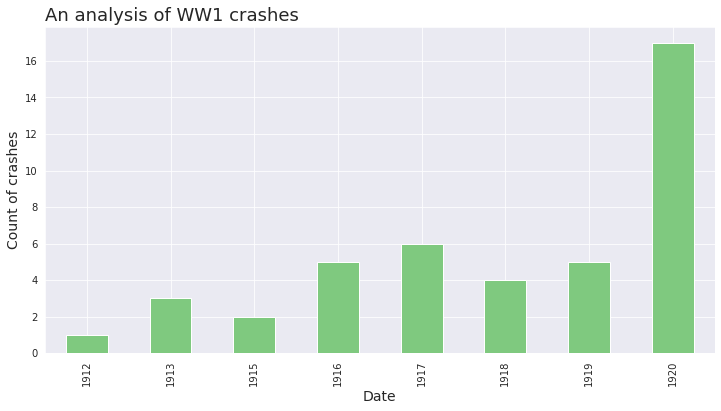

In [35]:
plot_data(crashes_ww.loc[1910:1920], 'An analysis of WW1 crashes', 'Date', 'Count of crashes', 'bar')

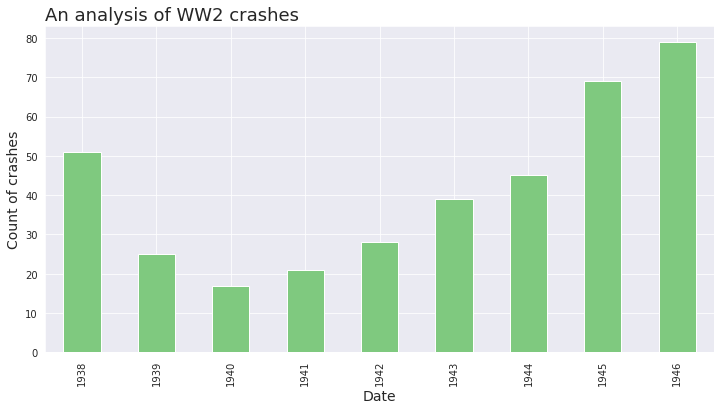

In [36]:
plot_data(crashes_ww.loc[1938:1946], 'An analysis of WW2 crashes', 'Date', 'Count of crashes', 'bar')

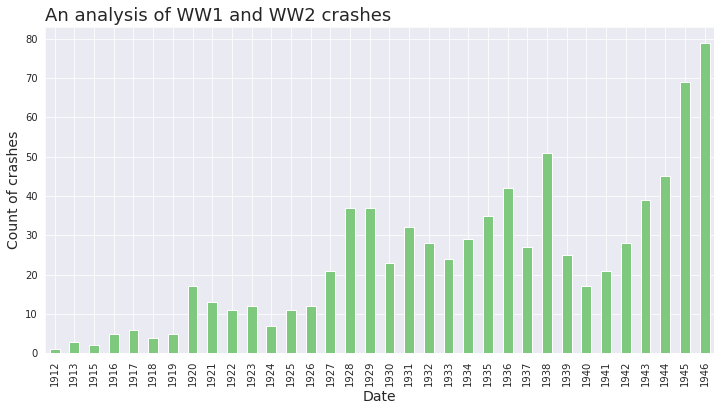

In [37]:
plot_data(crashes_ww.loc[1910:1946], 'An analysis of WW1 and WW2 crashes', 'Date', 'Count of crashes', 'bar')

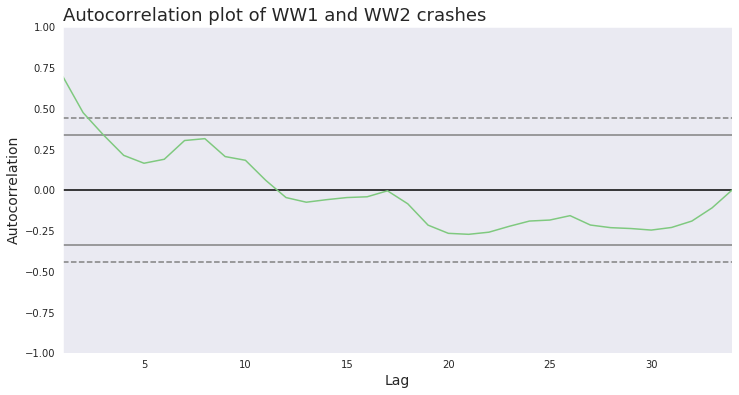

In [38]:
plot_data(crashes_ww.loc[1910:1946], 'Autocorrelation plot of WW1 and WW2 crashes', 'Lag', 'Autocorrelation', 'line', ac=True)

# Granger Causality Test Function

In [39]:
data_causality = pd.DataFrame()
data_causality['Time'] = data['Time']
data_causality['Date'] = date_year['Year']
data_causality['Fatalities'] = data['Fatalities']
data_causality['Aboard'] = data['Aboard']
data_causality['Ground'] = data['Ground']

In [40]:
data_causality.dtypes

Time          float64
Date            int64
Fatalities      int16
Aboard        float64
Ground          int16
dtype: object

In [41]:
def drop_missing_data_rows_to_causality(data: pd.DataFrame):
    missing_data_rows = pd.isna(data["Date"])|pd.isna(data["Time"])|pd.isna(data["Fatalities"])|pd.isna(data["Ground"])|pd.isna(data["Aboard"])
    return data.drop(data[missing_data_rows].index, axis=0)

In [42]:
data_causality = drop_missing_data_rows_to_causality(data_causality)

In [43]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False, maxlag=5):    
    """
    Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [44]:
grangers = grangers_causation_matrix(data_causality, variables=data_causality.columns)

In [45]:
grangers.rename_axis('Predict', axis='columns', inplace=True)

> In statistics, statistical significance means that the result that was produced has a reason behind it, it was not produced randomly, or by chance.

Techniques used in the tests:

- Null Hypothesis

> It assumes that the observation is not statistically significant.

- Alpha value

> Alpha value is the level of significance. Example: How close to extremes the data must be for null hypothesis to be rejected. It is usually taken as 0.01, 0.05, or 0.1.

- P value

> P value tells how close to extreme the data actually is. P value and alpha values are compared to establish the statistical significance.If p value <= alpha we reject the null hypothesis and say that the data is statistically significant. otherwise we accept the null hypothesis.

In [46]:
describe(grangers)

DescribeResult(nobs=5, minmax=(array([0.2514, 0.    , 0.0136, 0.0012, 0.2273]), array([1., 1., 1., 1., 1.])), mean=array([0.52466, 0.25182, 0.38318, 0.30588, 0.64816]), variance=array([0.12125347, 0.18658527, 0.17569287, 0.16774968, 0.07893457]), skewness=array([ 0.53200052,  1.29103822,  0.63680205,  1.13353796, -0.37851004]), kurtosis=array([-1.55116249, -0.08309636, -1.22490318, -0.23593316, -0.6513322 ]))

> Assuming a significance level of 0.05, if the p-value is lesser than 0.05, then we do NOT reject the null hypothesis that X does NOT granger cause Y. So, in the below table, the p-value for X=Date and Y=Fatalities is 0.0 and X=Date and Y=Aboard is 0.0. So we reject the null hypothesis and conclude that X (Date) granger causes Y (Fatalities) and  X (Date) granger causes Y (Aboard). That means, Date will likely be helpful in predicting the Fatalities and Aboard.

In [47]:
grangers

Predict,Time_x,Date_x,Fatalities_x,Aboard_x,Ground_x
Time_y,1.0000,0.0074,0.0136,0.0012,0.2273
Date_y,0.2851,1.0000,0.6310,0.2953,0.7527
Fatalities_y,0.2921,0.0000,1.0000,0.0058,0.6708
Aboard_y,0.2514,0.0000,0.1060,1.0000,0.5900
Ground_y,0.7947,0.2517,0.1653,0.2271,1.0000


In [48]:
grangers_pred = pd.DataFrame()
grangers_pred['Date'] = grangers['Date_x']
grangers_pred['Fatalities'] = grangers['Fatalities_x']
grangers_pred['Aboard'] = grangers['Aboard_x']

## Time Series analysis and visualization

In [49]:
data_causality_updated = pd.DataFrame()
data_causality_updated['Date'] = data_causality['Date']
data_causality_updated['Aboard'] = data_causality['Aboard']
data_causality_updated['Fatalities'] = data_causality['Fatalities']

### Time series visualization

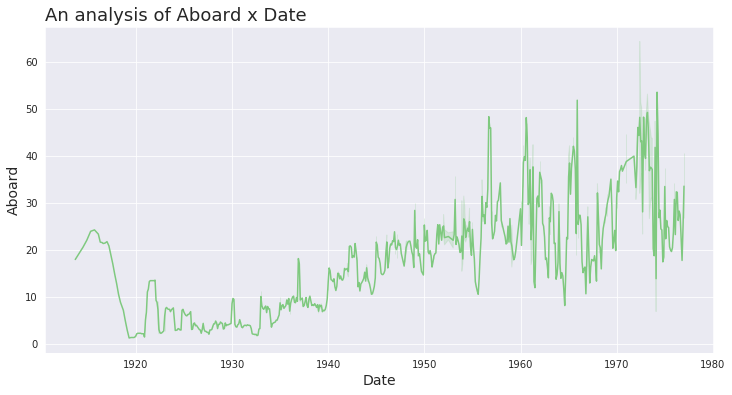

In [50]:
plot_data(data_causality_updated.rolling(10).mean(), 'An analysis of Aboard x Date', 'Date', 'Aboard', 'line', ts=True)

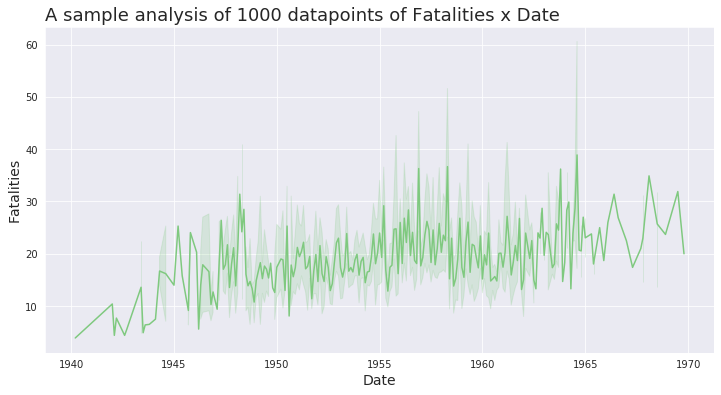

In [51]:
data_causality_updated_samples = data_causality_updated.sample(n=1000, random_state=1)

plot_data(data_causality_updated_samples.rolling(10).mean(), 'A sample analysis of 1000 datapoints of Fatalities x Date', 'Date', 'Fatalities', 'line', ts=True)

# Principal component analysis

### Definitions

> Principal component analysis (PCA) is a popular technique for analyzing large datasets containing a high number of dimensions/features per observation, increasing the interpretability of data while preserving the maximum amount of information, and enabling the visualization of multidimensional data. Formally, PCA is a statistical technique for reducing the dimensionality of a dataset. This is accomplished by linearly transforming the data into a new coordinate system where (most of) the variation in the data can be described with fewer dimensions than the initial data. Many studies use the first two principal components in order to plot the data in two dimensions and to visually identify clusters of closely related data points. Principal component analysis has applications in many fields such as population genetics, microbiome studies, and atmospheric science.

>PCA is an unsupervised linear dimensionality reduction algorithm to find a more meaningful basis or coordinate system for our data and works based on covariance matrix to find the strongest features if your samples. Its is used When we need to tackle the curse of dimensionality among data with linear relationships , i.e. where having too many dimensions (features) in your data causes noise and difficulties (it can be sound, picture or context). This specifically get worst when features have different scales (e.g. weight,length,area,speed, power, temperature,volume,time,cell number, etc. )

### We do this by reducing the dimension i.e. the features . But when should we reduce or change dimensions?

> 1- Better Perspective and less Complexity: When we need a more realistic perspective and we have many features on a given data set and specifically when we have this intuitive knowledge that we don’t need this much number of features.

### Similarly, in many other practices modelling is easier in 2D than 3D , right?

> 2 - Better visualization: When we cannot get a good visualization due to high number of dimensions we use PCA to reduce it into a shadow of 2D or 3D features (or even more but convenient enough for better parallel coordinates or Andrew Curve, e.g. when you transfer 100 features into 10 features you cannot still depict it as 2D or 3D but you can get a much better Andrew Curve)

> 3- Reduce size: When we have too much data and we are going to use process-intensive algorithms (like many supervised algorithms) on the data so we need to get rid of redundancy .

## Data normalization

In [52]:
def data_scaling(dataframe,inverse=False):
    scaler=StandardScaler()
    
    if inverse == False:
        return scaler.fit_transform(dataframe)
    else:
        scaler.fit(dataframe)
        return scaler.inverse_transform(dataframe)

In [53]:
data_causality_updated_scaled = data_scaling(data_causality_updated)

## PCA algorithm

In [54]:
data_causality_updated

,Date,Aboard,Fatalities
0,1908,2.0,1
1,1912,5.0,5
2,1913,1.0,1
3,1913,20.0,14
4,1913,30.0,30
...,...,...,...
3008,1977,13.0,13
3009,1977,164.0,131
3010,1977,5.0,5
3011,1977,2.0,2


In [55]:
pca = PCA(n_components=3)
principal_comp = pca.fit_transform(data_causality_updated_scaled)
principal_comp

array([[-2.02673109,  2.59098661,  0.07783342],
       [-1.76852093,  2.40798716,  0.03107301],
       [-1.92915881,  2.27477489,  0.04439528],
       ...,
       [-0.22455236, -1.6070504 , -0.10797636],
       [-0.36284579, -1.66063225, -0.09638024],
       [ 2.36487748, -0.63179672,  0.48403019]])

In [56]:
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1','pca2', 'pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-2.026731,2.590987,0.077833
1,-1.768521,2.407987,0.031073
2,-1.929159,2.274775,0.044395
3,-1.202720,2.551139,0.130598
4,-0.592322,2.792733,-0.067701


## Obtain optimal number of clusters using elbow method

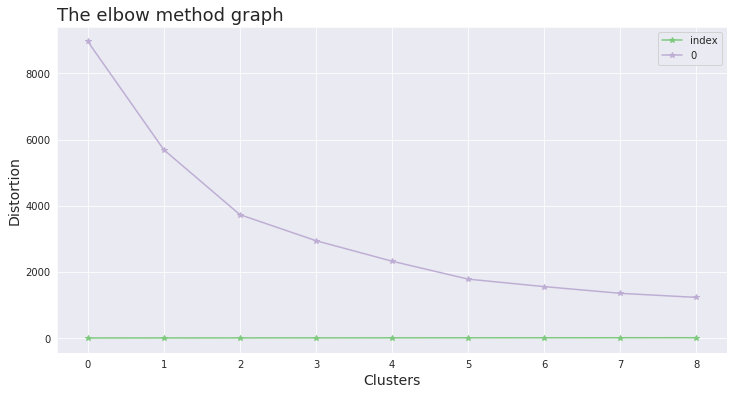

In [57]:
distortion = []

range_values = range(1, 10)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(data_causality_updated_scaled)
  distortion.append(kmeans.inertia_) 

distortion = pd.Series(distortion).reset_index()

plot_data(distortion, 'The elbow method graph', 'Clusters', 'Distortion',elbow=True)

In [58]:
kmeans = KMeans(3)
kmeans.fit(data_causality_updated_scaled)

pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':kmeans.labels_})], axis = 1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,-2.026731,2.590987,0.077833,2
1,-1.768521,2.407987,0.031073,2
2,-1.929159,2.274775,0.044395,2
3,-1.202720,2.551139,0.130598,2
4,-0.592322,2.792733,-0.067701,2


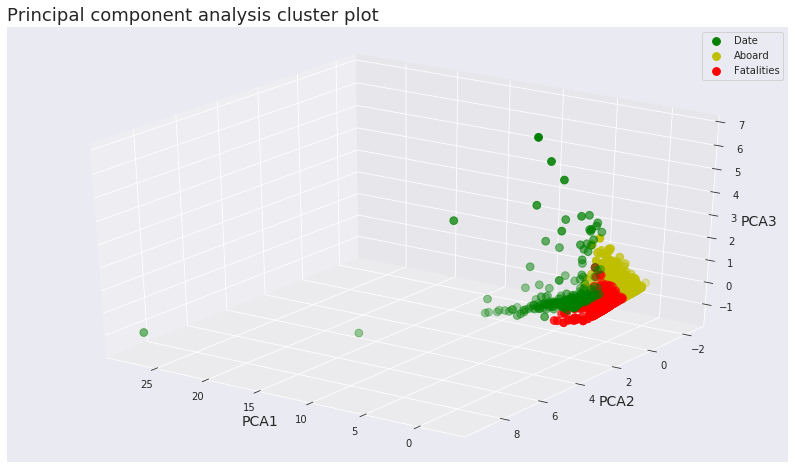

In [59]:
sns.set_palette('Accent')
sns.set_style('darkgrid')

Xax = principal_comp[:,0]
Yax = principal_comp[:,1]
Zax = principal_comp[:,2]

cdict = {0:'g',1:'y', 2:'r'}
label = {0:'Date',1:'Aboard', 2:'Fatalities'}

y = pca_df.cluster

fig = plt.figure(figsize=(14,8))

ax = fig.add_subplot(111, projection='3d')
 
for l in np.unique(y):
     ix=np.where(y==l)
     ax.scatter(Xax[ix], 
                Yax[ix], 
                Zax[ix], 
                c=cdict[l], 
                s=60,
               label=label[l])
 
ax.set_xlabel("PCA1", fontsize=14)
ax.set_ylabel("PCA2", fontsize=14)
ax.set_zlabel("PCA3", fontsize=14)
 
ax.view_init(30, 125)
ax.legend()
ax.set_title('Principal component analysis cluster plot', loc = 'left', fontsize=18)
ax=ax

In [60]:
pca.explained_variance_ratio_

array([0.66376793, 0.28480811, 0.05142396])